In [ ]:
# Part 0: Shared config & imports 
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pprint import pprint

RANDOM_STATE = 42
CSV_PATH = "diabetes_binary_health_indicators_BRFSS2015.csv"
OUTPUT_DIR = "model_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)


pd.set_option("display.max_columns", None)
print("Config ready. CSV_PATH:", CSV_PATH)

Config ready. CSV_PATH: diabetes_binary_health_indicators_BRFSS2015.csv


In [ ]:
# Part 1: Load & dtype optimization
def load_and_optimize_dtypes(csv_path: str, use_sample=False, sample_frac=0.25):
    df = pd.read_csv(csv_path)
    if use_sample:
        df = df.sample(frac=sample_frac, random_state=RANDOM_STATE).reset_index(drop=True)

    # dtype downcasts 
    binary_cols = [
        "HighBP", "HighChol", "CholCheck", "Smoker", "Stroke", "HeartDiseaseorAttack",
        "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump", "AnyHealthcare",
        "NoDocbcCost", "DiffWalk", "Sex"
    ]
    for c in binary_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], downcast="unsigned")

    if "BMI" in df.columns:
        df["BMI"] = pd.to_numeric(df["BMI"], downcast="float")
    for c in ["MentHlth", "PhysHlth", "GenHlth", "Age", "Education", "Income"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], downcast="unsigned")

    if "Diabetes_binary" in df.columns:
        df["Diabetes_binary"] = pd.to_numeric(df["Diabetes_binary"], downcast="unsigned")

    return df

df = load_and_optimize_dtypes(CSV_PATH, use_sample=False)
print("Loaded dataframe shape:", df.shape)
print("\nDtype summary (sample):")
print(df.dtypes.value_counts())
print("\nFirst 5 rows:")
display(df.head())


Loaded dataframe shape: (253680, 22)

Dtype summary (sample):
uint8      21
float32     1
Name: count, dtype: int64

First 5 rows:


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40.0,1,0,0,0,0,1,0,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25.0,1,0,0,1,0,0,0,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28.0,0,0,0,0,1,0,0,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27.0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24.0,0,0,0,1,1,1,0,1,0,2,3,0,0,0,11,5,4


In [ ]:
# Part 2: EDA
target_col = "Diabetes_binary"
assert target_col in df.columns, f"Target '{target_col}' not found."

print("Target distribution:")
print(df[target_col].value_counts(dropna=False))
print("\nTarget percentage positive:")
print(df[target_col].mean() * 100)

print("\nMissing values per column (top 20):")
print(df.isna().sum().sort_values(ascending=False).head(20))

# A few summary stats for numeric columns
num_cols = ["BMI", "MentHlth", "PhysHlth", "GenHlth", "Age"]
num_cols = [c for c in num_cols if c in df.columns]
if num_cols:
    print("\nNumeric summary:")
    display(df[num_cols].describe().T)
else:
    print("\nNo numeric columns from the expected list were found.")


Target distribution:
Diabetes_binary
0    218334
1     35346
Name: count, dtype: int64

Target percentage positive:
13.933301797540206

Missing values per column (top 20):
Diabetes_binary         0
HighBP                  0
Education               0
Age                     0
Sex                     0
DiffWalk                0
PhysHlth                0
MentHlth                0
GenHlth                 0
NoDocbcCost             0
AnyHealthcare           0
HvyAlcoholConsump       0
Veggies                 0
Fruits                  0
PhysActivity            0
HeartDiseaseorAttack    0
Stroke                  0
Smoker                  0
BMI                     0
CholCheck               0
dtype: int64

Numeric summary:


,count,mean,std,min,25%,50%,75%,max
BMI,253680.0,28.382364,6.607666,12.0,24.0,27.0,31.0,98.0
MentHlth,253680.0,3.184772,7.412847,0.0,0.0,0.0,2.0,30.0
PhysHlth,253680.0,4.242081,8.717951,0.0,0.0,0.0,3.0,30.0
GenHlth,253680.0,2.511392,1.068477,1.0,2.0,2.0,3.0,5.0
Age,253680.0,8.032119,3.054220,1.0,6.0,8.0,10.0,13.0


In [ ]:
# Part 3: Prepare X and y using selected 11 features
target_col = "Diabetes_binary"

# 11 selected features
selected_features = [
    "GenHlth", "HighBP", "DiffWalk", "BMI", "HighChol",
    "Age", "HeartDiseaseorAttack", "PhysHlth", "Income",
    "Education", "PhysActivity"
]

# Ensure all selected columns exist
missing = [c for c in selected_features if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# Define X and y
X = df[selected_features].copy()
y = df[target_col].astype(int)

# Identify numeric vs binary
numeric_cols = ["BMI", "GenHlth", "PhysHlth", "Age", "Education", "Income"]
binary_cols = [c for c in X.columns if c not in numeric_cols]

print("Using selected 11 features + target.")
print("Feature count:", X.shape[1])
print("Numeric columns:", numeric_cols)
print("Binary columns:", binary_cols)


✅ Using selected 11 features + target.
Feature count: 11
Numeric columns: ['BMI', 'GenHlth', 'PhysHlth', 'Age', 'Education', 'Income']
Binary columns: ['HighBP', 'DiffWalk', 'HighChol', 'HeartDiseaseorAttack', 'PhysActivity']


In [5]:
# Part 4: Splits (75% train, 25% test; then val from train)
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

# Now create a validation set from X_temp (10% of training)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.10, random_state=RANDOM_STATE, stratify=y_temp
)

print("Sizes -> Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train positive rate:", y_train.mean(), "Test positive rate:", y_test.mean())


Sizes -> Train: (171234, 11) Val: (19026, 11) Test: (63420, 11)
Train positive rate: 0.13932980599647266 Test positive rate: 0.13934090192368337


In [6]:
# Part 5: Build preprocessor and fit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

def build_preprocessor(numeric_cols, binary_cols):
    numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("bin", "passthrough", binary_cols)
    ], remainder="drop")
    return preprocessor

preprocessor = build_preprocessor(numeric_cols, binary_cols)
preprocessor.fit(X_train)  # fit only on train

# Optionally sanity check
_ = preprocessor.transform(X_train.iloc[:3])
print("Preprocessor ready. Feature count after transform:", preprocessor.transform(X_train[:1]).shape[1])


Preprocessor ready. Feature count after transform: 11


In [7]:
# Part 6: Resampling libs + helpers
!pip install -q imbalanced-learn xgboost

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score, precision_recall_curve
)
import numpy as np
import pandas as pd
from pprint import pprint
from pathlib import Path

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Four class imbalance strategies
samplers = {
    "SMOTE": SMOTE(random_state=RANDOM_STATE),
    "ADASYN": ADASYN(random_state=RANDOM_STATE),
    "SMOTE+Tomek": SMOTETomek(random_state=RANDOM_STATE),
    "SMOTE+ENN": SMOTEENN(random_state=RANDOM_STATE)
}

# We'll also include a "None" option to compare against no-resampling baseline
samplers_with_none = {"None": None, **samplers}

def pick_best_threshold(y_true_val, proba_val):
    """Pick threshold maximizing F1 on validation set (uses probabilities of positive class)."""
    precisions, recalls, thresholds = precision_recall_curve(y_true_val, proba_val)
    # precision_recall_curve returns thresholds of length n-1
    f1s = (2 * precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-12)
    best_idx = np.argmax(f1s)
    best_thr = thresholds[best_idx]
    return float(best_thr), float(f1s[best_idx])


In [ ]:
# Part 7: Model builders
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

def build_model(name: str):
    if name == "LogisticRegression":
        return LogisticRegression(
            solver="saga", penalty="l2", max_iter=2000,
            class_weight="balanced", random_state=RANDOM_STATE, n_jobs=1
        )
    if name == "DecisionTree":
        return DecisionTreeClassifier(
            max_depth=None, min_samples_split=10, min_samples_leaf=5,
            class_weight="balanced", random_state=RANDOM_STATE
        )
    if name == "RandomForest":
        return RandomForestClassifier(
            n_estimators=300, max_depth=None, min_samples_split=10, min_samples_leaf=5,
            class_weight="balanced_subsample", n_jobs=-1, random_state=RANDOM_STATE
        )
    if name == "KNN":
        
        return KNeighborsClassifier(n_neighbors=31, weights="distance", metric="minkowski")
    if name == "XGBoost":
        
        pos = np.sum(y_train == 1); neg = np.sum(y_train == 0)
        spw = max(1.0, neg / max(1.0, pos))
        return XGBClassifier(
            objective="binary:logistic",
            n_estimators=800, learning_rate=0.05,
            max_depth=6, subsample=0.8, colsample_bytree=0.8,
            reg_alpha=0.1, reg_lambda=0.5,
            tree_method="hist",
            eval_metric="auc",
            random_state=RANDOM_STATE,
            scale_pos_weight=spw,
            n_jobs=1
        )
    if name == "LightGBM":
        pos = np.sum(y_train == 1); neg = np.sum(y_train == 0)
        spw = max(1.0, neg / max(1.0, pos))
        return lgb.LGBMClassifier(
            objective="binary",
            boosting_type="gbdt",
            n_estimators=1200,
            learning_rate=0.05,
            num_leaves=31,
            max_depth=7,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=RANDOM_STATE,
            n_jobs=1,
            scale_pos_weight=spw
        )
    raise ValueError(f"Unknown model name: {name}")

model_names = [
    "LogisticRegression",
    "DecisionTree",
    "RandomForest",
    "KNN",
    "XGBoost",
    "LightGBM"
]



=== Resampling: None ===
[LogisticRegression | None] -> {'model': 'LogisticRegression', 'sampler': 'None', 'thr_val_best_f1': 0.6225, 'val_best_f1': 0.4641, 'test_accuracy': 0.7966, 'test_precision': 0.3629, 'test_recall': 0.6086, 'test_f1': 0.4546, 'test_roc_auc': 0.8173, 'test_pr_auc': 0.3907}


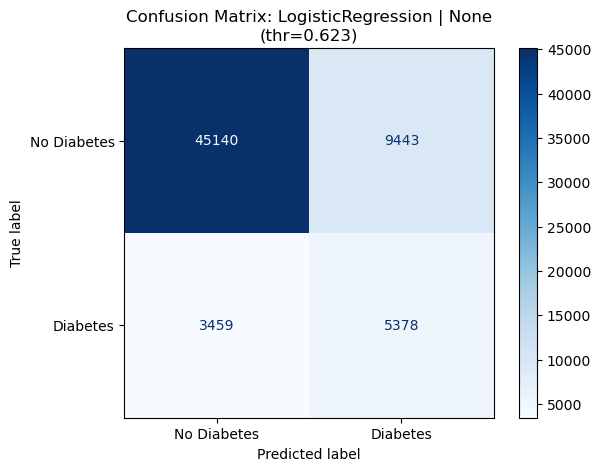

[DecisionTree | None] -> {'model': 'DecisionTree', 'sampler': 'None', 'thr_val_best_f1': 0.6275, 'val_best_f1': 0.3668, 'test_accuracy': 0.7655, 'test_precision': 0.2941, 'test_recall': 0.4878, 'test_f1': 0.367, 'test_roc_auc': 0.7001, 'test_pr_auc': 0.2884}


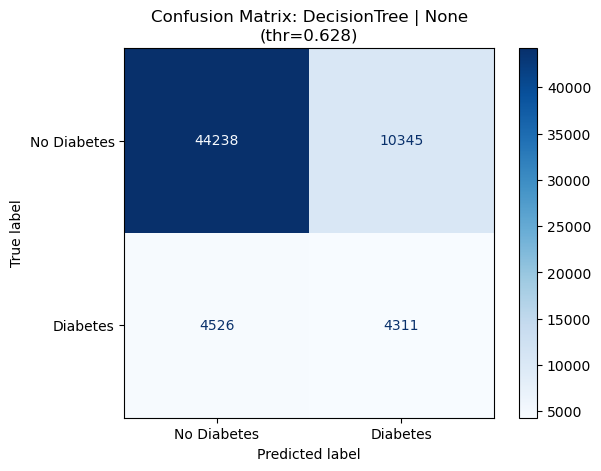

[RandomForest | None] -> {'model': 'RandomForest', 'sampler': 'None', 'thr_val_best_f1': 0.5409, 'val_best_f1': 0.4563, 'test_accuracy': 0.8037, 'test_precision': 0.3674, 'test_recall': 0.5663, 'test_f1': 0.4457, 'test_roc_auc': 0.8097, 'test_pr_auc': 0.4}


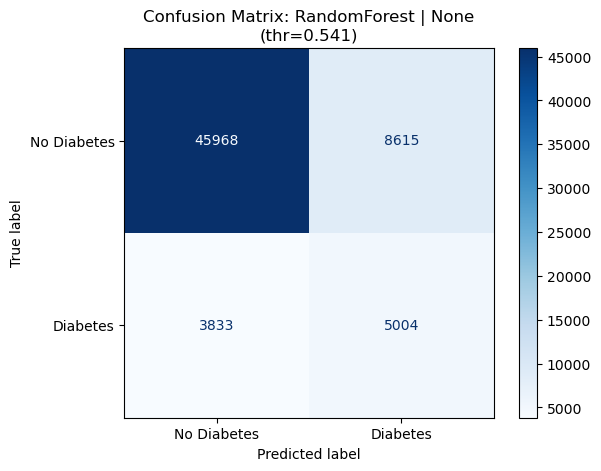

[KNN | None] -> {'model': 'KNN', 'sampler': 'None', 'thr_val_best_f1': 0.2173, 'val_best_f1': 0.432, 'test_accuracy': 0.7736, 'test_precision': 0.3291, 'test_recall': 0.6017, 'test_f1': 0.4255, 'test_roc_auc': 0.7557, 'test_pr_auc': 0.3163}


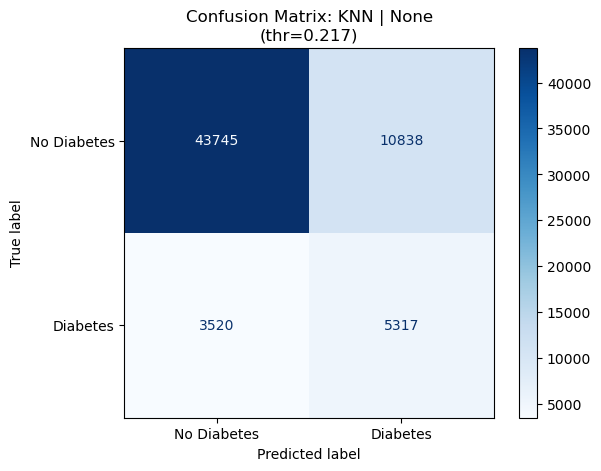

[XGBoost | None] -> {'model': 'XGBoost', 'sampler': 'None', 'thr_val_best_f1': 0.6697, 'val_best_f1': 0.4687, 'test_accuracy': 0.8174, 'test_precision': 0.3903, 'test_recall': 0.5528, 'test_f1': 0.4575, 'test_roc_auc': 0.8184, 'test_pr_auc': 0.4102}


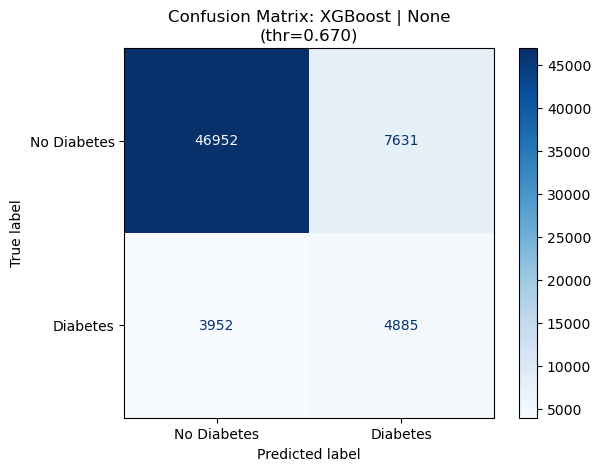

[LightGBM] [Info] Number of positive: 23858, number of negative: 147376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 153
[LightGBM] [Info] Number of data points in the train set: 171234, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139330 -> initscore=-1.820868
[LightGBM] [Info] Start training from score -1.820868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

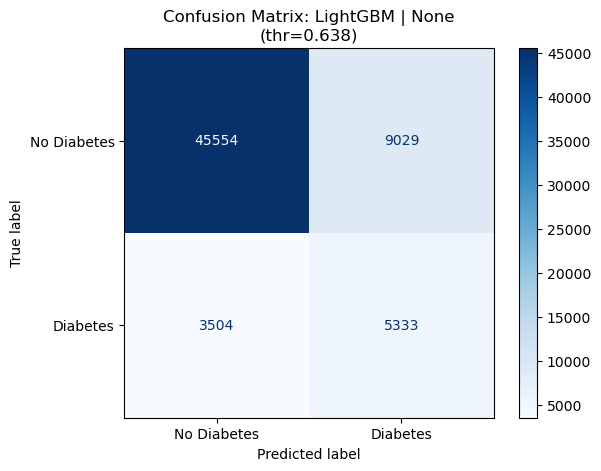


=== Resampling: SMOTE ===
[LogisticRegression | SMOTE] -> {'model': 'LogisticRegression', 'sampler': 'SMOTE', 'thr_val_best_f1': 0.6325, 'val_best_f1': 0.4637, 'test_accuracy': 0.7996, 'test_precision': 0.3657, 'test_recall': 0.5966, 'test_f1': 0.4535, 'test_roc_auc': 0.8169, 'test_pr_auc': 0.3893}


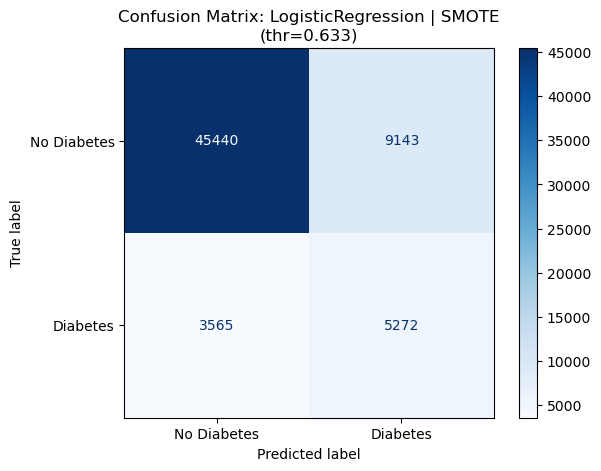

[DecisionTree | SMOTE] -> {'model': 'DecisionTree', 'sampler': 'SMOTE', 'thr_val_best_f1': 0.2, 'val_best_f1': 0.3676, 'test_accuracy': 0.7164, 'test_precision': 0.2649, 'test_recall': 0.5833, 'test_f1': 0.3643, 'test_roc_auc': 0.6964, 'test_pr_auc': 0.2716}


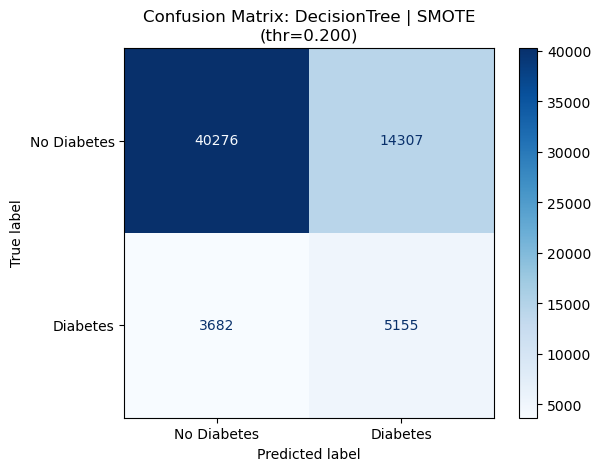

[RandomForest | SMOTE] -> {'model': 'RandomForest', 'sampler': 'SMOTE', 'thr_val_best_f1': 0.4059, 'val_best_f1': 0.4471, 'test_accuracy': 0.7996, 'test_precision': 0.3592, 'test_recall': 0.5587, 'test_f1': 0.4373, 'test_roc_auc': 0.8055, 'test_pr_auc': 0.3812}


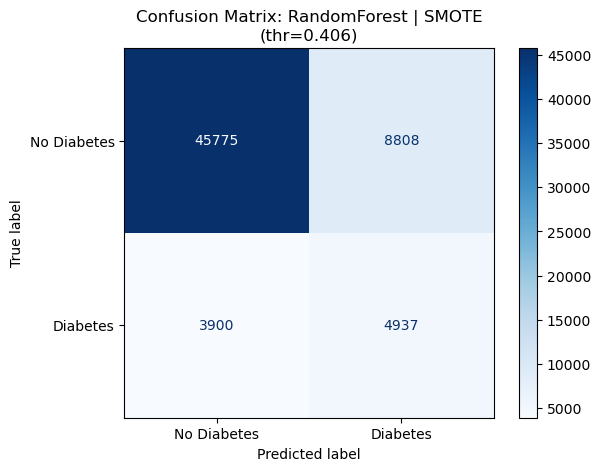

[KNN | SMOTE] -> {'model': 'KNN', 'sampler': 'SMOTE', 'thr_val_best_f1': 0.6385, 'val_best_f1': 0.4247, 'test_accuracy': 0.7909, 'test_precision': 0.3396, 'test_recall': 0.5303, 'test_f1': 0.414, 'test_roc_auc': 0.7509, 'test_pr_auc': 0.3094}


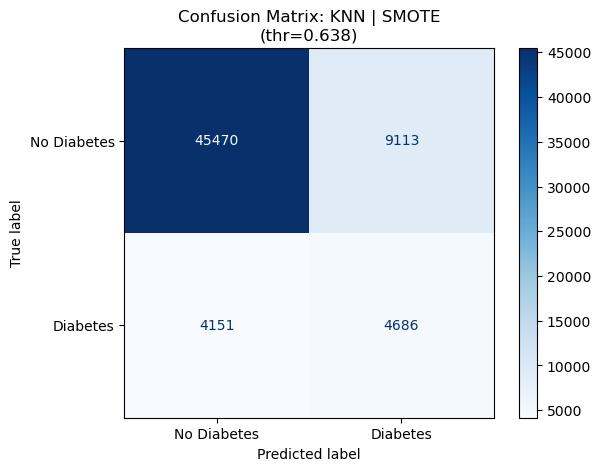

[XGBoost | SMOTE] -> {'model': 'XGBoost', 'sampler': 'SMOTE', 'thr_val_best_f1': 0.7132, 'val_best_f1': 0.4614, 'test_accuracy': 0.8044, 'test_precision': 0.3707, 'test_recall': 0.578, 'test_f1': 0.4517, 'test_roc_auc': 0.8156, 'test_pr_auc': 0.4054}


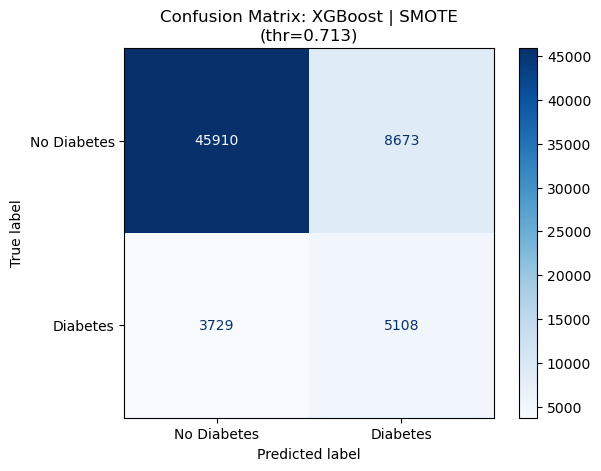

[LightGBM] [Info] Number of positive: 147376, number of negative: 147376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 294752, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM | SMOTE] -> {'model': 'LightGBM', 'sampler': 'SMOTE', 'thr_val_best_f1': 0.6696, 'val_best_f1': 0.4632, 'test_accuracy': 0.7962, 'test_precision': 0.3621, 'test_recall': 0.6078, 'test_f1': 0.4539, 'test_roc_auc': 0.8159, 'test_pr_auc': 0.4043}


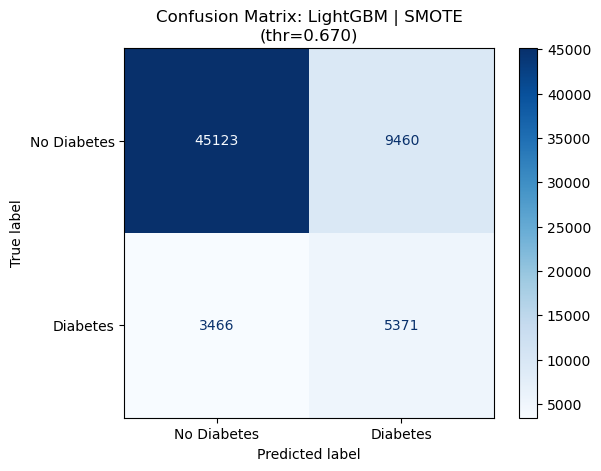


=== Resampling: ADASYN ===
[LogisticRegression | ADASYN] -> {'model': 'LogisticRegression', 'sampler': 'ADASYN', 'thr_val_best_f1': 0.6402, 'val_best_f1': 0.462, 'test_accuracy': 0.798, 'test_precision': 0.3633, 'test_recall': 0.5978, 'test_f1': 0.4519, 'test_roc_auc': 0.8166, 'test_pr_auc': 0.388}


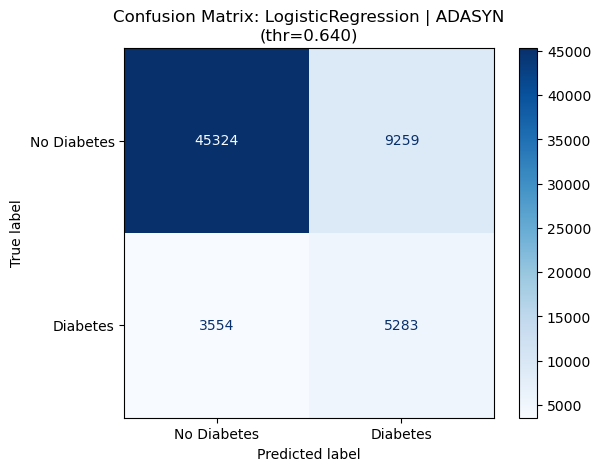

[DecisionTree | ADASYN] -> {'model': 'DecisionTree', 'sampler': 'ADASYN', 'thr_val_best_f1': 0.1956, 'val_best_f1': 0.3657, 'test_accuracy': 0.7172, 'test_precision': 0.2649, 'test_recall': 0.5802, 'test_f1': 0.3638, 'test_roc_auc': 0.6973, 'test_pr_auc': 0.2695}


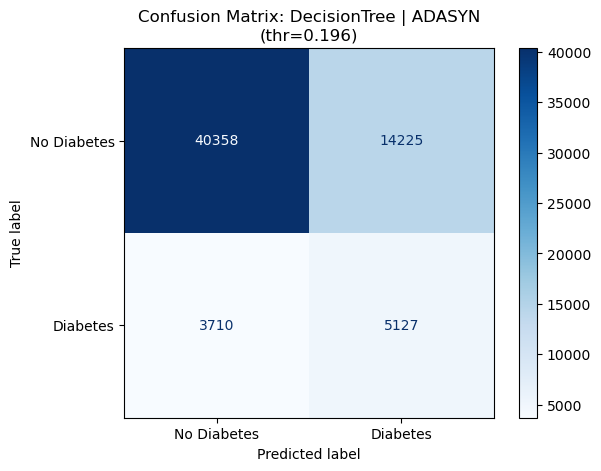

[RandomForest | ADASYN] -> {'model': 'RandomForest', 'sampler': 'ADASYN', 'thr_val_best_f1': 0.3911, 'val_best_f1': 0.4411, 'test_accuracy': 0.7911, 'test_precision': 0.3483, 'test_recall': 0.573, 'test_f1': 0.4333, 'test_roc_auc': 0.8031, 'test_pr_auc': 0.3759}


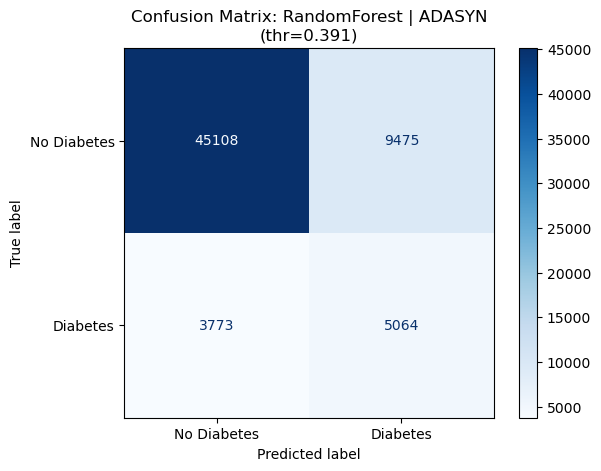

[KNN | ADASYN] -> {'model': 'KNN', 'sampler': 'ADASYN', 'thr_val_best_f1': 0.6359, 'val_best_f1': 0.419, 'test_accuracy': 0.7775, 'test_precision': 0.3253, 'test_recall': 0.5557, 'test_f1': 0.4103, 'test_roc_auc': 0.747, 'test_pr_auc': 0.3004}


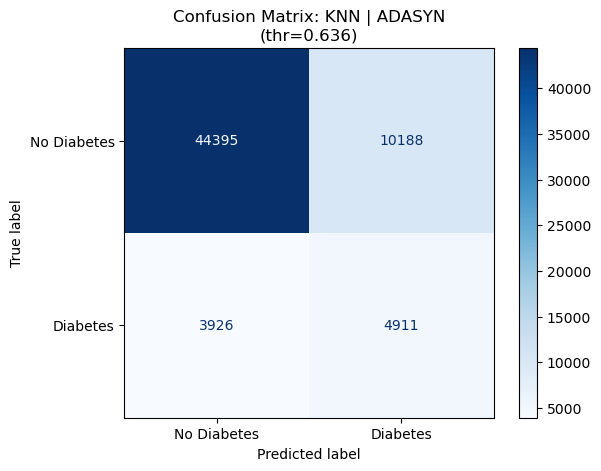

[XGBoost | ADASYN] -> {'model': 'XGBoost', 'sampler': 'ADASYN', 'thr_val_best_f1': 0.7148, 'val_best_f1': 0.461, 'test_accuracy': 0.806, 'test_precision': 0.373, 'test_recall': 0.5763, 'test_f1': 0.4529, 'test_roc_auc': 0.8146, 'test_pr_auc': 0.4052}


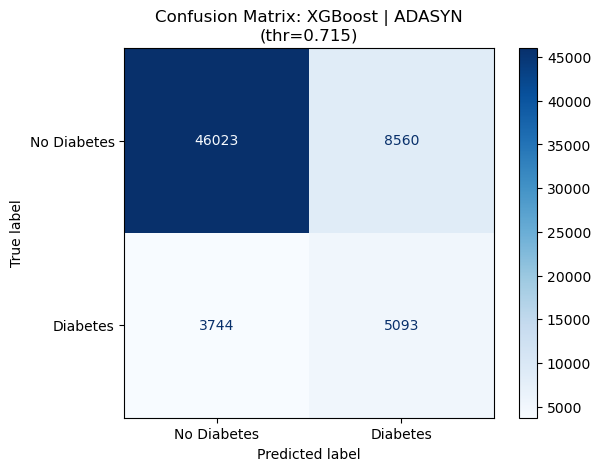

[LightGBM] [Info] Number of positive: 151537, number of negative: 147376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 298913, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506960 -> initscore=0.027843
[LightGBM] [Info] Start training from score 0.027843
[LightGBM | ADASYN] -> {'model': 'LightGBM', 'sampler': 'ADASYN', 'thr_val_best_f1': 0.7008, 'val_best_f1': 0.4637, 'test_accuracy': 0.8119, 'test_precision': 0.3806, 'test_recall': 0.5578, 'test_f1': 0.4525, 'test_roc_auc': 0.8155, 'test_pr_auc': 0.4055}


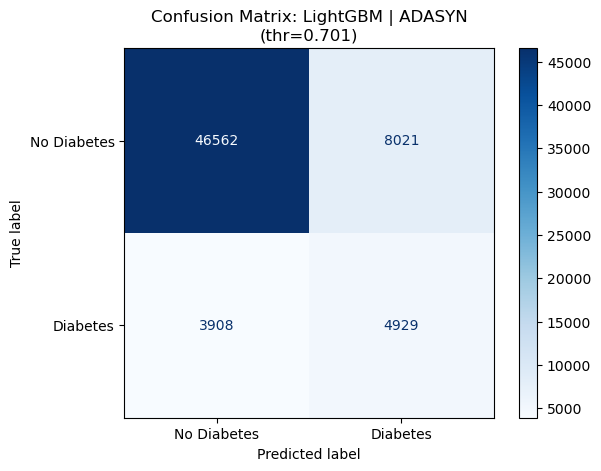


=== Resampling: SMOTE+Tomek ===
[LogisticRegression | SMOTE+Tomek] -> {'model': 'LogisticRegression', 'sampler': 'SMOTE+Tomek', 'thr_val_best_f1': 0.6357, 'val_best_f1': 0.4644, 'test_accuracy': 0.7999, 'test_precision': 0.3661, 'test_recall': 0.596, 'test_f1': 0.4536, 'test_roc_auc': 0.8169, 'test_pr_auc': 0.3894}


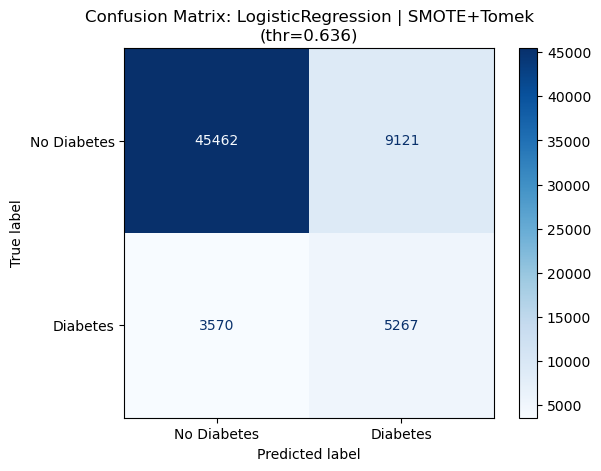

[DecisionTree | SMOTE+Tomek] -> {'model': 'DecisionTree', 'sampler': 'SMOTE+Tomek', 'thr_val_best_f1': 0.2, 'val_best_f1': 0.3696, 'test_accuracy': 0.7162, 'test_precision': 0.266, 'test_recall': 0.5893, 'test_f1': 0.3666, 'test_roc_auc': 0.6975, 'test_pr_auc': 0.2708}


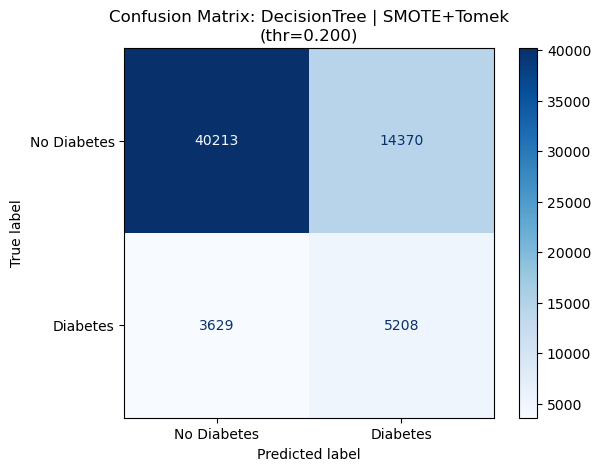

[RandomForest | SMOTE+Tomek] -> {'model': 'RandomForest', 'sampler': 'SMOTE+Tomek', 'thr_val_best_f1': 0.3828, 'val_best_f1': 0.4491, 'test_accuracy': 0.7864, 'test_precision': 0.3463, 'test_recall': 0.6005, 'test_f1': 0.4393, 'test_roc_auc': 0.8058, 'test_pr_auc': 0.3822}


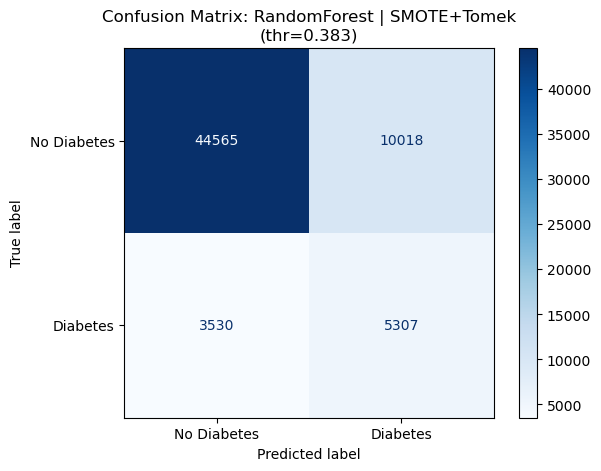

[KNN | SMOTE+Tomek] -> {'model': 'KNN', 'sampler': 'SMOTE+Tomek', 'thr_val_best_f1': 0.6447, 'val_best_f1': 0.4267, 'test_accuracy': 0.7904, 'test_precision': 0.3388, 'test_recall': 0.5304, 'test_f1': 0.4135, 'test_roc_auc': 0.753, 'test_pr_auc': 0.3106}


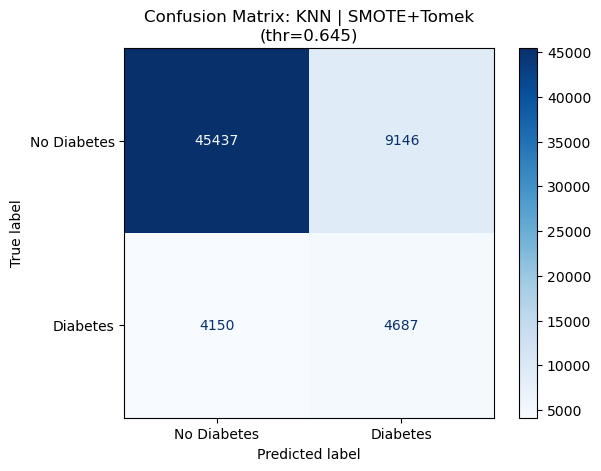

[XGBoost | SMOTE+Tomek] -> {'model': 'XGBoost', 'sampler': 'SMOTE+Tomek', 'thr_val_best_f1': 0.7097, 'val_best_f1': 0.4595, 'test_accuracy': 0.8029, 'test_precision': 0.3688, 'test_recall': 0.5833, 'test_f1': 0.4519, 'test_roc_auc': 0.8155, 'test_pr_auc': 0.4063}


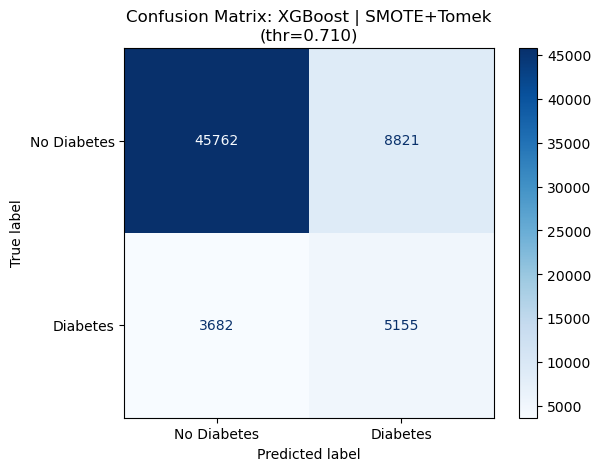

[LightGBM] [Info] Number of positive: 145574, number of negative: 145574
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 291148, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM | SMOTE+Tomek] -> {'model': 'LightGBM', 'sampler': 'SMOTE+Tomek', 'thr_val_best_f1': 0.7043, 'val_best_f1': 0.4657, 'test_accuracy': 0.8119, 'test_precision': 0.3803, 'test_recall': 0.5561, 'test_f1': 0.4517, 'test_roc_auc': 0.8154, 'test_pr_auc': 0.4049}


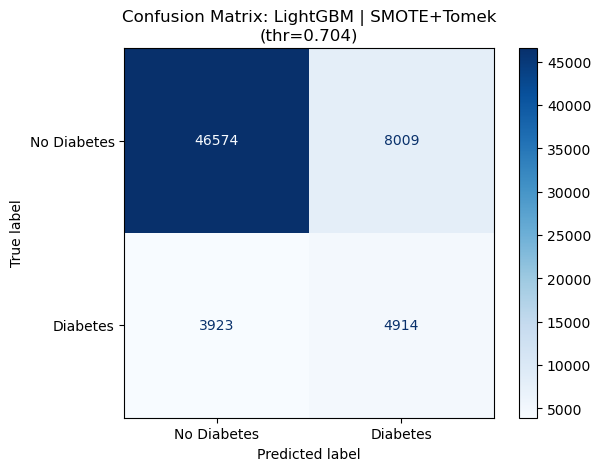


=== Resampling: SMOTE+ENN ===
[LogisticRegression | SMOTE+ENN] -> {'model': 'LogisticRegression', 'sampler': 'SMOTE+ENN', 'thr_val_best_f1': 0.742, 'val_best_f1': 0.4669, 'test_accuracy': 0.7928, 'test_precision': 0.3589, 'test_recall': 0.6192, 'test_f1': 0.4544, 'test_roc_auc': 0.8171, 'test_pr_auc': 0.3903}


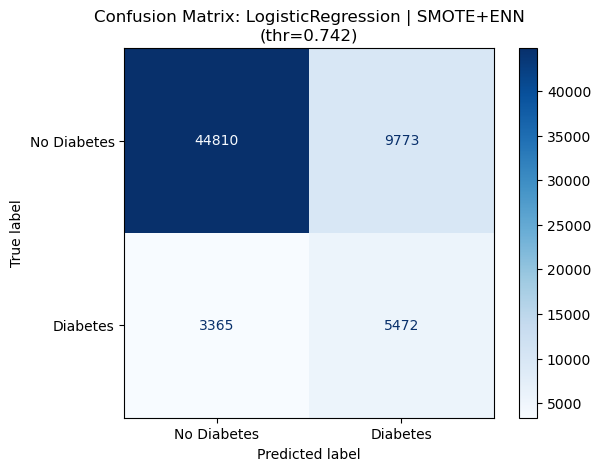

[DecisionTree | SMOTE+ENN] -> {'model': 'DecisionTree', 'sampler': 'SMOTE+ENN', 'thr_val_best_f1': 0.4679, 'val_best_f1': 0.4232, 'test_accuracy': 0.7781, 'test_precision': 0.3309, 'test_recall': 0.5794, 'test_f1': 0.4212, 'test_roc_auc': 0.7486, 'test_pr_auc': 0.3076}


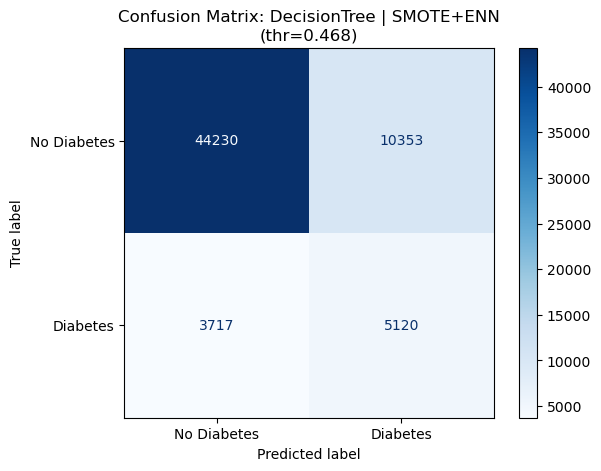

[RandomForest | SMOTE+ENN] -> {'model': 'RandomForest', 'sampler': 'SMOTE+ENN', 'thr_val_best_f1': 0.6046, 'val_best_f1': 0.4607, 'test_accuracy': 0.8047, 'test_precision': 0.3728, 'test_recall': 0.5882, 'test_f1': 0.4563, 'test_roc_auc': 0.8155, 'test_pr_auc': 0.4007}


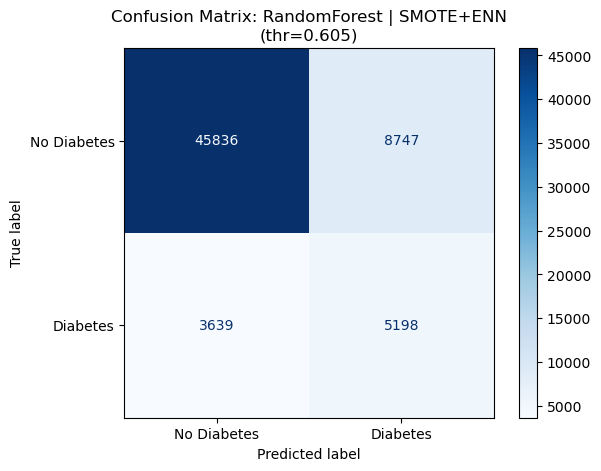

[KNN | SMOTE+ENN] -> {'model': 'KNN', 'sampler': 'SMOTE+ENN', 'thr_val_best_f1': 0.7519, 'val_best_f1': 0.4395, 'test_accuracy': 0.7662, 'test_precision': 0.3265, 'test_recall': 0.638, 'test_f1': 0.4319, 'test_roc_auc': 0.7762, 'test_pr_auc': 0.3307}


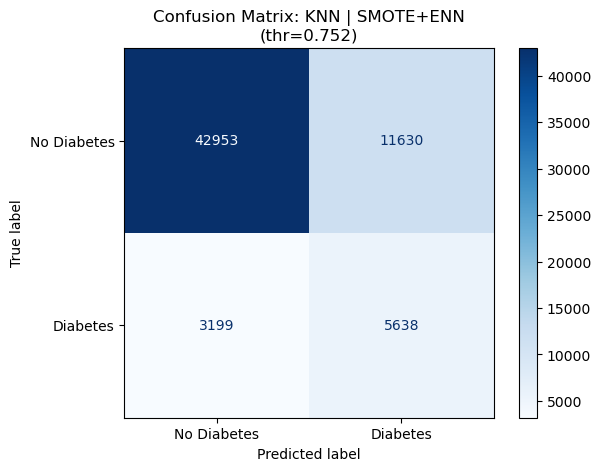

[XGBoost | SMOTE+ENN] -> {'model': 'XGBoost', 'sampler': 'SMOTE+ENN', 'thr_val_best_f1': 0.8412, 'val_best_f1': 0.4695, 'test_accuracy': 0.8149, 'test_precision': 0.388, 'test_recall': 0.5684, 'test_f1': 0.4612, 'test_roc_auc': 0.8202, 'test_pr_auc': 0.4141}


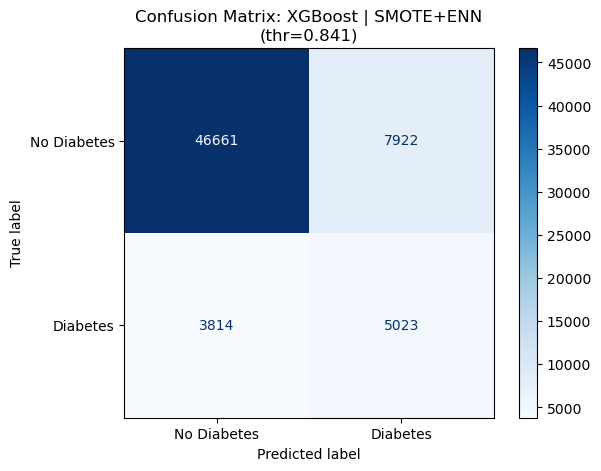

[LightGBM] [Info] Number of positive: 115241, number of negative: 101348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 216589, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532072 -> initscore=0.128465
[LightGBM] [Info] Start training from score 0.128465
[LightGBM | SMOTE+ENN] -> {'model': 'LightGBM', 'sampler': 'SMOTE+ENN', 'thr_val_best_f1': 0.8565, 'val_best_f1': 0.4678, 'test_accuracy': 0.8241, 'test_precision': 0.4005, 'test_recall': 0.5287, 'test_f1': 0.4558, 'test_roc_auc': 0.8181, 'test_pr_auc': 0.4117}


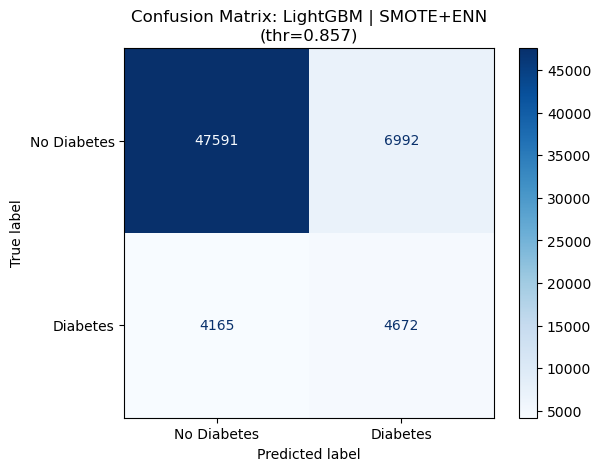

,model,sampler,thr_val_best_f1,val_best_f1,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_pr_auc
0,DecisionTree,SMOTE+ENN,0.467928,0.423219,0.778146,0.330899,0.579382,0.421226,0.748584,0.307558
1,DecisionTree,None,0.627518,0.366832,0.765516,0.294146,0.487835,0.367003,0.700135,0.288403
2,DecisionTree,SMOTE+Tomek,0.200000,0.369593,0.716194,0.266013,0.589340,0.366567,0.697539,0.270787
3,DecisionTree,SMOTE,0.200000,0.367601,0.716351,0.264875,0.583343,0.364324,0.696416,0.271641
4,DecisionTree,ADASYN,0.195582,0.365680,0.717203,0.264934,0.580174,0.363759,0.697250,0.269469
5,KNN,SMOTE+ENN,0.751923,0.439527,0.766178,0.326500,0.637999,0.431948,0.776220,0.330745
6,KNN,None,0.217283,0.431960,0.773605,0.329124,0.601675,0.425496,0.755729,0.316278
7,KNN,SMOTE,0.638456,0.424688,0.790855,0.339590,0.530270,0.414031,0.750929,0.309428
8,KNN,SMOTE+Tomek,0.644735,0.426702,0.790350,0.338827,0.530384,0.413498,0.752971,0.310577
9,KNN,ADASYN,0.635876,0.418966,0.777452,0.325253,0.555732,0.410344,0.746973,0.300397


Saved results to: model_output/imbalance_model_results_11_features.csv


In [ ]:
# Part 8: Train/eval loop with confusion matrix plots
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_pipeline(model_name, sampler_name, sampler, verbose=False, plot_cm=True):
    """Build pipeline: Preprocess -> (Sampler?) -> Model, tune threshold on val, then test."""
    steps = [("preprocessor", preprocessor)]
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("clf", build_model(model_name)))
    
    pipe = ImbPipeline(steps=steps)
    pipe.fit(X_train, y_train)

    # Validation probabilities for threshold selection
    proba_val = pipe.predict_proba(X_val)[:, 1]
    thr, best_val_f1 = pick_best_threshold(y_val, proba_val)

    # Evaluate on test at tuned threshold
    proba_test = pipe.predict_proba(X_test)[:, 1]
    preds_test = (proba_test >= thr).astype(int)

    # Compute metrics
    metrics = {
        "model": model_name,
        "sampler": sampler_name,
        "thr_val_best_f1": thr,
        "val_best_f1": best_val_f1,
        "test_accuracy": accuracy_score(y_test, preds_test),
        "test_precision": precision_score(y_test, preds_test, zero_division=0),
        "test_recall": recall_score(y_test, preds_test, zero_division=0),
        "test_f1": f1_score(y_test, preds_test, zero_division=0),
        "test_roc_auc": roc_auc_score(y_test, proba_test),
        "test_pr_auc": average_precision_score(y_test, proba_test)
    }

    if verbose:
        print(f"[{model_name} | {sampler_name}] ->", {k: round(v,4) if isinstance(v, float) else v for k,v in metrics.items()})

    # Plot confusion matrix
    if plot_cm:
        cm = confusion_matrix(y_test, preds_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"Confusion Matrix: {model_name} | {sampler_name}\n(thr={thr:.3f})")
        plt.show()

    return metrics, pipe


# Run full loop
all_results = []
best_pipelines = {}

for sampler_name, sampler in samplers_with_none.items():
    print(f"\n=== Resampling: {sampler_name} ===")
    for model_name in model_names:
        res, pipe = evaluate_pipeline(model_name, sampler_name, sampler, verbose=True, plot_cm=True)
        all_results.append(res)
        best_pipelines[(model_name, sampler_name)] = pipe

results_df = pd.DataFrame(all_results).sort_values(["model", "test_f1"], ascending=[True, False]).reset_index(drop=True)
display(results_df.head(20))

results_csv = Path(OUTPUT_DIR) / "imbalance_model_results_11_features.csv"
results_df.to_csv(results_csv, index=False)
print("Saved results to:", results_csv)
